In [1]:
import pandas as pd
import numpy as np
import perception.util.conversion as conv
import os
import cv2
import scipy
import math
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

plt.style.use("seaborn-v0_8")

### Import and process BEV and tracking poses

In [2]:
experiments_dir = f'{os.getcwd()}/../../../../perception_debug'
run1_path = f'{experiments_dir}/run1'
run2_path = f'{experiments_dir}/run2'

bev_paths_run1 = [f'{run1_path}/bev/{f}' for f in os.listdir(f'{run1_path}/bev') if os.path.isdir(f'{run1_path}/bev/{f}')]
bev_paths_run2 = [f'{run2_path}/bev/{f}' for f in os.listdir(f'{run2_path}/bev') if os.path.isdir(f'{run2_path}/bev/{f}')]

tracking_paths_run1 = [f'{run1_path}/ego/{f}/color' for f in os.listdir(f'{run1_path}/ego') if os.path.isdir(f'{run1_path}/ego/{f}')]
tracking_paths_run2 = [f'{run2_path}/ego/{f}/color' for f in os.listdir(f'{run2_path}/ego') if os.path.isdir(f'{run2_path}/ego/{f}')]
# bev_path = f'{experiments_dir}/run/bev'
# ego_path = f'{experiments_dir}/50 expo-128 gain/color'
# bev_ego_pose_path = f'{bev_path}/ego_poses.csv'
# tracking_csv_path = f'{ego_path}/opp_rel_poses.csv'

def process_single_run(bev_path, ego_path, window_before_start_time=1, selected_bev_cam="right"):
  start_time = int(np.loadtxt(f'{bev_path}/start_time.txt')) / 1e9

  ego_pose_df = process_poses(
    pd.read_csv(f'{bev_path}/bev/{selected_bev_cam}/ego_poses.csv'), start_time, window_before_start_time)

  opp_pose_df = process_poses(
    pd.read_csv(f'{bev_path}/bev/{selected_bev_cam}/opp_poses.csv'), start_time, window_before_start_time)

  tracking_df = process_poses(
    pd.read_csv(f'{ego_path}/opp_rel_poses.csv'), start_time, window_before_start_time)

  return ego_pose_df, opp_pose_df, tracking_df

def process_all_runs(bev_paths, ego_paths, window_before_start_time=1):
  bev_run_data = []
  if len(bev_paths) != len(ego_paths):
    raise ValueError("The number of BEV and ego paths should be the same")

  for bev_path, ego_path in zip(bev_paths, ego_paths):
    start_time = int(np.loadtxt(f'{bev_path}/start_time.txt')) / 1e9
    ego_pose_df, opp_pose_df, tracking_df = process_single_run(bev_path, ego_path, window_before_start_time)
    
    bev_run_data.append({
      "start_time": start_time,
      "ego_pose_df": ego_pose_df,
      "opp_pose_df": opp_pose_df,
      "tracking_df": tracking_df
    })
  return bev_run_data

def process_poses(poses_df: pd.DataFrame, start_time, window_before_start_time=1):
  poses_df["time (sec)"] = poses_df["time"] / 1e9
  
  # Include a few frames before the trajectory start time
  poses_df_start_time: pd.DataFrame = poses_df[poses_df["time (sec)"] > start_time]
  first_index = poses_df_start_time.index.min()

  if window_before_start_time >= 1:
    poses_df_start_time = pd.concat([poses_df.iloc[first_index - window_before_start_time:first_index], poses_df_start_time])

  poses_df_start_time = poses_df_start_time.reset_index(drop=True)

  # normalise the time from df to start at 0
  poses_df_start_time['time_norm (sec)'] = (poses_df_start_time['time (sec)'] - start_time)

  return poses_df_start_time

run1_data = process_all_runs(bev_paths_run1, tracking_paths_run1)
run2_data = process_all_runs(bev_paths_run2, tracking_paths_run2)

In [79]:
# TODO: Add uncertainty to these measurements
BEV_TO_BACK_OPP_X = -100.0
BEV_TO_BACK_OPP_Y = 0.0
BEV_TO_BACK_OPP_Z = -120.0

BEV_TO_CAM_EGO_X = -184.8
BEV_TO_CAM_EGO_Y = -39.5
BEV_TO_CAM_EGO_Z = 12.5

### Analyze single run for now

In [4]:
run_num = 5
ego_bev_df: pd.DataFrame = run1_data[run_num]["ego_pose_df"].dropna().reset_index(drop=True)
opp_bev_df: pd.DataFrame = run1_data[run_num]["opp_pose_df"].dropna().reset_index(drop=True)
tracking_df: pd.DataFrame = run1_data[run_num]["tracking_df"].dropna().reset_index(drop=True)

In [5]:
ego_bev_df.head()

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec)
0,1726384313321838073,-0.962578,-0.270994,0.001769,0.001651,-3.020853,-0.850460,0.005553,1.361644,1.130132,2.951103,1.726384e+09,-0.007849
1,1726384313338715360,0.962832,0.267502,0.035725,0.011030,3.003766,0.834533,0.111452,1.348934,1.120491,2.920577,1.726384e+09,0.009028
2,1726384313355197960,0.962152,0.272512,-0.000891,0.001005,3.020757,0.855574,-0.002799,1.360494,1.129266,2.948996,1.726384e+09,0.025511
3,1726384313371756899,0.962758,0.270345,0.003219,0.000318,3.023982,0.849141,0.010112,1.358207,1.127839,2.943894,1.726384e+09,0.042070
4,1726384313388340515,0.962603,0.270912,0.001399,0.000247,3.023631,0.850960,0.004393,1.358124,1.127845,2.944731,1.726384e+09,0.058654


### Test difference with pose estimation on distorted and undistorted images

In [6]:
side_length = 0.15
half_side_length = side_length / 2

# Define the 4 corners of the ArUco marker
marker_obj_points = np.array([[
    [-half_side_length, half_side_length, 0],
    [half_side_length, half_side_length, 0],
    [half_side_length, -half_side_length, 0],
    [-half_side_length, -half_side_length, 0]
]], dtype=np.float32)

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
detector_params = cv2.aruco.DetectorParameters()
detector_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_SUBPIX

(array([[1.44603966],
        [1.08844077],
        [2.93652588]]),
 (-179.16827183986018, 1.0943357116704733, 30.755713188304476),
 array([[1.44419423],
        [1.08695973],
        [2.93380379]]),
 (-177.96907495324257, -0.8861895527568258, 31.849526965060225),
 array([[1.44419864],
        [1.08696278],
        [2.93381277]]),
 (-177.96912050622188, -0.8857461911180717, 31.849676763687743))

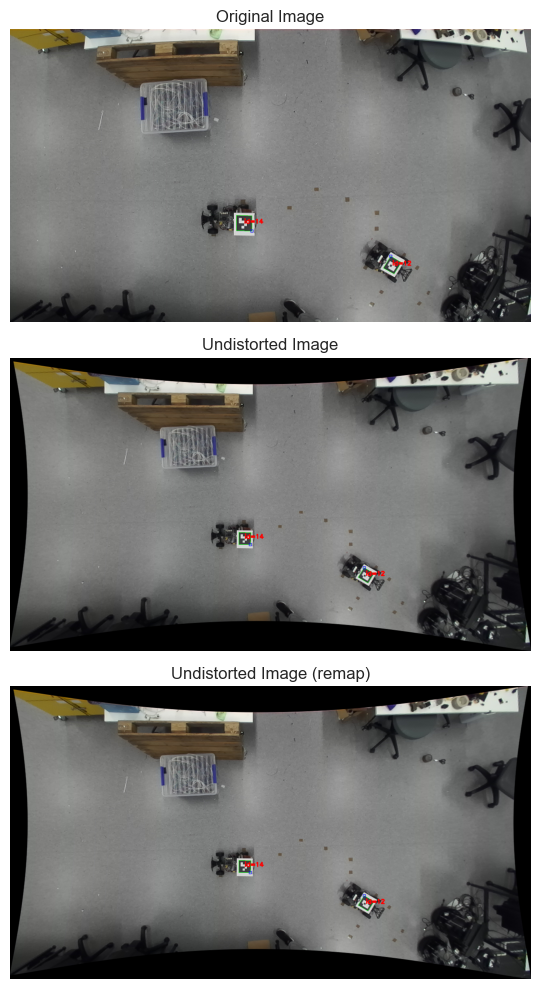

In [7]:
image = cv2.imread(f'{run1_path}/bev/24_09_15_18:50:11/bev/left/1726383014030341577.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

intrinsics = np.loadtxt(f'{run1_path}/bev/24_09_15_18:50:11/bev/left/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run1_path}/bev/24_09_15_18:50:11/bev/left/dist_coeffs.txt')

new_img_size = (int(image.shape[1] * 1.2), int(image.shape[0] * 1.2))
# not specifying new image size
new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)

# specifying new image size
new_intrinsics2, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
mapx, mapy = cv2.initUndistortRectifyMap(intrinsics, dist_coeffs, None, new_intrinsics, image.shape[:2][::-1], m1type=cv2.CV_32FC1)
undistorted_image2 = cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)

und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)
und2_corners, und2_ids, _ = cv2.aruco.detectMarkers(undistorted_image2, dictionary, parameters=detector_params)
corners, ids, _ = cv2.aruco.detectMarkers(image, cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50), parameters=detector_params)

_, rvec_und, tvec_und = cv2.solvePnP(marker_obj_points, und_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und), degrees=True)

_, rvec_und2, tvec_und2 = cv2.solvePnP(marker_obj_points, und2_corners[0], new_intrinsics, None,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler_und2 = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec_und2), degrees=True)

_, rvec, tvec = cv2.solvePnP(marker_obj_points, corners[1], intrinsics, dist_coeffs,  flags=cv2.SOLVEPNP_IPPE_SQUARE)
euler = conv.get_euler_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec), degrees=True)

image_draw = cv2.aruco.drawDetectedMarkers(image.copy(), corners, ids)
und_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)
und2_image_draw = cv2.aruco.drawDetectedMarkers(undistorted_image2.copy(), und2_corners, und2_ids)

plt.figure(figsize=(6, 10))
plt.subplot(3, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(image_draw)
plt.title("Original Image")
plt.subplot(3, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(und_image_draw)
plt.title("Undistorted Image")
plt.subplot(3, 1, 3)
plt.grid(False)
plt.axis('off')
plt.imshow(und2_image_draw)
plt.title("Undistorted Image (remap)")
plt.tight_layout()

tvec, euler, tvec_und, euler_und, tvec_und2, euler_und2

In [132]:
rvec = ego_bev_df[["ax", "ay", "az"]].values[0]
quat = conv.get_quaternion_from_rodrigues(rvec)
# Sanity checking conversions
rvec, conv.get_quaternion_from_rodrigues(rvec), \
conv.get_rotation_matrix_from_quaternion(*conv.get_quaternion_from_rodrigues(rvec)), cv2.Rodrigues(rvec)[0], \
conv.get_euler_from_quaternion(*quat), \
conv.get_euler_from_rotation_matrix(conv.get_rotation_matrix_from_quaternion(*quat))

(array([3.02480861, 0.83262235, 0.05183749]),
 array([0.9640068 , 0.26535682, 0.01652061, 0.00192617]),
 array([[ 0.85862565,  0.51154792,  0.03287421],
        [ 0.51167521, -0.85916409,  0.00505403],
        [ 0.03082972,  0.0124814 , -0.99944672]]),
 array([[ 0.85862565,  0.51154792,  0.03287421],
        [ 0.51167521, -0.85916409,  0.00505403],
        [ 0.03082972,  0.0124814 , -0.99944672]]),
 (3.1291049909620683, -0.030834605633778704, 0.5374166897822876),
 (3.1291049909620683, -0.030834605633778704, 0.5374166897822876))

In [178]:
import importlib

importlib.reload(conv)

<module 'perception.util.conversion' from '/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/build/perception/perception/util/conversion.py'>

In [18]:
def stabilise_euler_angles(df: pd.DataFrame) -> pd.DataFrame:
  """
  Stabilise the Euler angles by ensuring that the difference 
  between consecutive angles is less than 180 degrees
  """
  for i, row in df.iterrows():
    if i == 0:
      continue
    prev_roll, prev_pitch, prev_yaw = df.loc[i - 1, ["roll", "pitch", "yaw"]]
    roll, pitch, yaw = row[["roll", "pitch", "yaw"]]

    if abs(prev_roll - roll) > 180:
      df.loc[i, "roll"] = (roll + 360 * np.sign(prev_roll - roll)) % 360
    if abs(prev_pitch - pitch) > 180:
      df.loc[i, "pitch"] = (pitch + 360 * np.sign(prev_pitch - pitch)) % 360
    if abs(prev_yaw - yaw) > 180:
      df.loc[i, "yaw"] = (yaw + 360 * np.sign(prev_yaw - yaw)) % 360

  return df

In [19]:
ego_bev_df['roll'], ego_bev_df['pitch'], ego_bev_df['yaw'] = \
  zip(*ego_bev_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))
opp_bev_df['roll'], opp_bev_df['pitch'], opp_bev_df['yaw'] = \
  zip(*opp_bev_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))
tracking_df['roll'], tracking_df['pitch'], tracking_df['yaw'] = \
  zip(*tracking_df.apply(lambda row: conv.get_euler_from_quaternion(*row[['qx','qy','qz','qw']], degrees=True), axis=1))

ego_bev_df = stabilise_euler_angles(ego_bev_df)
opp_bev_df = stabilise_euler_angles(opp_bev_df)
tracking_df = stabilise_euler_angles(tracking_df)

In [81]:
num = 3
ego_cam_in_ego_top_marker_frame = np.array([BEV_TO_CAM_EGO_X, BEV_TO_CAM_EGO_Y, BEV_TO_CAM_EGO_Z]) / 1000
ego_top_marker_to_bev_rot = cv2.Rodrigues(ego_bev_df.iloc[num][["ax", "ay", "az"]].to_numpy())[0]
# cv2.Rodrigues(np.array([math.pi, 0.0, 0.0]))[0]

ego_cam_in_ego_top_marker_frame_rot_to_bev = ego_top_marker_to_bev_rot @ ego_cam_in_ego_top_marker_frame
ego_top_marker_in_bev_frame = ego_bev_df.iloc[0][["tx", "ty", "tz"]].to_numpy()

ego_cam_in_bev_frame = ego_top_marker_in_bev_frame + ego_cam_in_ego_top_marker_frame_rot_to_bev
print(conv.get_euler_from_rotation_matrix(ego_top_marker_to_bev_rot, degrees=True))
print(conv.get_quaternion_from_rotation_matrix(ego_top_marker_to_bev_rot))

ego_cam_in_ego_top_marker_frame, ego_cam_in_ego_top_marker_frame_rot_to_bev, \
ego_top_marker_in_bev_frame, ego_cam_in_bev_frame

(179.86520087850926, -0.3453175615263872, 31.37013368879688)
[9.62758162e-01 2.70344700e-01 3.21926575e-03 3.17847594e-04]


(array([-0.1848, -0.0395,  0.0125]),
 array([-0.17826562, -0.06245831, -0.01370644]),
 array([1.36164439, 1.13013248, 2.9511029 ]),
 array([1.18337876, 1.06767417, 2.93739646]))

In [82]:
opp_back_in_opp_top_marker_frame = np.array([BEV_TO_BACK_OPP_X, BEV_TO_BACK_OPP_Y, BEV_TO_BACK_OPP_Z]) / 1000
opp_top_marker_to_bev_rot = cv2.Rodrigues(opp_bev_df.iloc[num][["ax", "ay", "az"]].to_numpy())[0]

opp_back_in_opp_top_marker_frame_rot_to_bev = opp_top_marker_to_bev_rot @ opp_back_in_opp_top_marker_frame
opp_top_marker_in_bev_frame = opp_bev_df.iloc[0][["tx", "ty", "tz"]].to_numpy()

opp_back_in_bev_frame = opp_top_marker_in_bev_frame + opp_back_in_opp_top_marker_frame_rot_to_bev

opp_back_in_opp_top_marker_frame, opp_back_in_opp_top_marker_frame_rot_to_bev, \
opp_top_marker_in_bev_frame, opp_back_in_bev_frame

(array([-0.1 ,  0.  , -0.12]),
 array([0.0892769 , 0.0042806 , 0.12810664]),
 array([-0.27364383,  0.58274272,  2.77213244]),
 array([-0.18436693,  0.58702332,  2.90023908]))

In [84]:
rel_pose = tracking_df.iloc[1][["tx", "ty", "tz"]].to_numpy()
np.linalg.norm(rel_pose)

1.389370772984217

In [85]:
np.linalg.norm(opp_back_in_bev_frame - ego_cam_in_bev_frame)

1.4502186714321088

In [80]:
ego_bev_df.head()

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
0,1726384313321838073,-0.962578,-0.270994,0.001769,0.001651,-3.020853,-0.850460,0.005553,1.361644,1.130132,2.951103,1.726384e+09,-0.007849,-179.762900,0.143886,31.447272
1,1726384313338715360,0.962832,0.267502,0.035725,0.011030,3.003766,0.834533,0.111452,1.348934,1.120491,2.920577,1.726384e+09,0.009028,177.682678,-3.605887,31.126609
2,1726384313355197960,0.962152,0.272512,-0.000891,0.001005,3.020757,0.855574,-0.002799,1.360494,1.129266,2.948996,1.726384e+09,0.025511,179.917073,0.129653,31.627499
3,1726384313371756899,0.962758,0.270345,0.003219,0.000318,3.023982,0.849141,0.010112,1.358207,1.127839,2.943894,1.726384e+09,0.042070,179.865201,-0.345318,31.370134
4,1726384313388340515,0.962603,0.270912,0.001399,0.000247,3.023631,0.850960,0.004393,1.358124,1.127845,2.944731,1.726384e+09,0.058654,179.929313,-0.146608,31.437162


In [78]:
tracking_df.head()

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
0,1726384313272412160,0.674968,0.692563,0.187173,0.172456,1.915194,1.965120,0.531096,-0.278416,-0.048689,1.359072,1.726384e+09,-0.057275,150.520648,-0.790579,91.682294
1,1726384313372483072,0.676184,0.692442,0.183854,0.171748,1.919391,1.965540,0.521883,-0.278715,-0.048782,1.360253,1.726384e+09,0.042796,150.862211,-0.618129,91.521799
2,1726384313405840128,0.674953,0.692363,0.190013,0.170196,1.917531,1.966993,0.539823,-0.278840,-0.045569,1.359196,1.726384e+09,0.076153,150.463912,-1.193198,91.773593
3,1726384313439196928,0.678326,0.690980,0.180545,0.172696,1.924469,1.960372,0.512222,-0.277395,-0.042602,1.362340,1.726384e+09,0.109510,151.065851,-0.359693,91.151809
4,1726384313472554240,0.680277,0.695369,0.168945,0.158566,1.945109,1.988261,0.483063,-0.274945,-0.040477,1.377384,1.726384e+09,0.142867,153.210363,-0.534841,91.384477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,1726384318075899136,-0.699295,-0.709426,0.049831,0.072236,-2.101274,-2.131715,0.149734,0.410357,-0.042311,1.271900,1.726384e+09,4.746212,189.893831,-1.879564,90.661352
141,1726384318109257472,-0.698548,-0.709035,0.059929,0.075558,-2.094878,-2.126329,0.179721,0.410985,-0.042335,1.273280,1.726384e+09,4.779571,190.987638,-1.342000,90.724693
142,1726384318142616064,-0.698782,-0.708822,0.058748,0.076314,-2.094640,-2.124733,0.176101,0.410930,-0.042326,1.273086,1.726384e+09,4.812929,190.952926,-1.494563,90.673962
143,1726384318175974400,-0.699281,-0.707968,0.055478,0.081909,-2.089195,-2.115147,0.165747,0.411018,-0.042170,1.272373,1.726384e+09,4.846287,191.142493,-2.200027,90.492706


In [57]:
ego_bev_df[["time", "tx", "ty", "tz"]]

# subtract the camera to BEV ego transformation
ego_bev_df["tx"] -= BEV_TO_CAM_EGO_X
ego_bev_df["ty"] -= BEV_TO_CAM_EGO_Y
ego_bev_df["tz"] -= BEV_TO_CAM_EGO_Z

,time,tx,ty,tz
0,1726384313272412160,-0.278416,-0.048689,1.359072
1,1726384313372483072,-0.278715,-0.048782,1.360253
2,1726384313405840128,-0.278840,-0.045569,1.359196
3,1726384313439196928,-0.277395,-0.042602,1.362340
4,1726384313472554240,-0.274945,-0.040477,1.377384
...,...,...,...,...
140,1726384318075899136,0.410357,-0.042311,1.271900
141,1726384318109257472,0.410985,-0.042335,1.273280
142,1726384318142616064,0.410930,-0.042326,1.273086
143,1726384318175974400,0.411018,-0.042170,1.272373


In [44]:
ego_bev_df.head()

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
0,1726384313321838073,-0.962578,-0.270994,0.001769,0.001651,-3.020853,-0.850460,0.005553,1.361644,1.130132,2.951103,1.726384e+09,-0.007849,-179.762900,0.143886,31.447272
1,1726384313338715360,0.962832,0.267502,0.035725,0.011030,3.003766,0.834533,0.111452,1.348934,1.120491,2.920577,1.726384e+09,0.009028,177.682678,-3.605887,31.126609
2,1726384313355197960,0.962152,0.272512,-0.000891,0.001005,3.020757,0.855574,-0.002799,1.360494,1.129266,2.948996,1.726384e+09,0.025511,179.917073,0.129653,31.627499
3,1726384313371756899,0.962758,0.270345,0.003219,0.000318,3.023982,0.849141,0.010112,1.358207,1.127839,2.943894,1.726384e+09,0.042070,179.865201,-0.345318,31.370134
4,1726384313388340515,0.962603,0.270912,0.001399,0.000247,3.023631,0.850960,0.004393,1.358124,1.127845,2.944731,1.726384e+09,0.058654,179.929313,-0.146608,31.437162


In [52]:
opp_bev_df.head()

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
0,1726384313321838073,-0.006026,0.999037,-0.010380,0.042203,-0.018440,3.056941,-0.031762,-0.273644,0.582743,2.772132,1.726384e+09,-0.007849,-178.778090,4.829995,-179.257235
1,1726384313338715360,-0.004304,0.998999,-0.018790,0.040372,-0.013183,3.060257,-0.057560,-0.273902,0.583208,2.774367,1.726384e+09,0.009028,-177.821483,4.617371,-179.418518
2,1726384313355197960,-0.006461,0.999116,-0.008053,0.040740,-0.019787,3.059927,-0.024664,-0.273549,0.582249,2.770141,1.726384e+09,0.025511,-179.044613,4.663531,-179.220096
3,1726384313371756899,-0.006187,0.998975,-0.012516,0.043069,-0.018920,3.055130,-0.038277,-0.273686,0.582743,2.772220,1.726384e+09,0.042070,-178.531150,4.927445,-179.227155
4,1726384313388340515,-0.011003,0.999014,0.022732,0.036521,-0.033785,3.067555,0.069802,-0.272141,0.577875,2.751959,1.726384e+09,0.058654,177.435884,4.213306,-178.832304


In [10]:
ego_bev_df.iloc[16:18]

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
16,1726384313604604651,-0.969597,-0.244080,0.017490,0.000534,-3.045045,-0.766539,0.054929,1.368681,1.144166,3.019411,1.726384e+09,0.274918,180.548798,1.928751,28.268568
17,1726384313621230850,0.846189,0.226054,-0.411448,0.252139,2.301367,0.614794,-1.119008,1.372387,1.153570,3.055387,1.726384e+09,0.291544,155.747916,54.127155,17.384619


[ 0.84662294  0.226684   -0.40991299  0.25261691] [ 0.84662294 -0.226684    0.40991299 -0.25261691]
[12] (155.72246180854566, 53.96053180570488, 17.480790341201317)
[-0.97128448 -0.2311113   0.04760795  0.03045512] [-0.97128448  0.2311113  -0.04760795 -0.03045512]
[12] (-175.3299649846084, 4.496872458855628, 26.95205265529238)
(array([[ 2.30197809],
       [ 0.61635656],
       [-1.11455842]]), array([[-2.99359849],
       [-0.71230876],
       [ 0.14673258]])) (array([[1.37340579],
       [1.15439793],
       [3.05779639]]), array([[1.37197408],
       [1.15355411],
       [3.05248904]])) [[0.37517387]
 [0.55588377]]

[ 0.00821279  0.96873265 -0.24396488  0.04439299] [ 0.00821279 -0.96873265  0.24396488 -0.04439299]
[14] (-151.71432185610388, 5.164593542261593, -179.66928139308374)
[-0.00909077  0.99719489  0.0404743   0.06230201] [-0.00909077 -0.99719489 -0.0404743  -0.06230201]
[14] (175.39891166662346, 7.180200343100739, -179.2442056410933)
(array([[ 0.02509657],
       [ 2.9602436

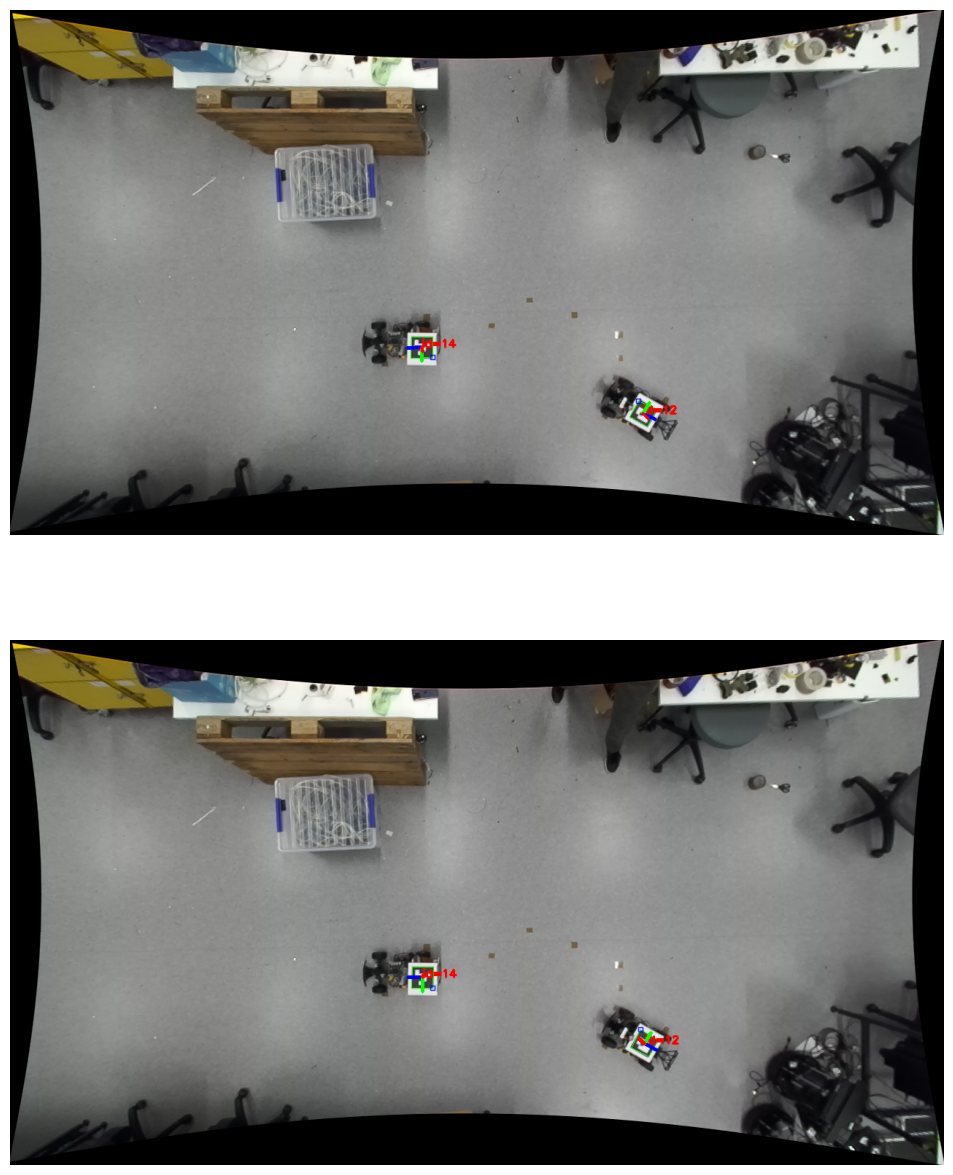

In [51]:
import perception.util.aruco as aruco

num = 17
image_prev = cv2.imread(f'{run1_path}/bev/24_09_15_19:11:47/bev/right/{ego_bev_df["time"].iloc[num - 1]}.png')
image_prev = cv2.cvtColor(image_prev, cv2.COLOR_BGR2RGB)

image = cv2.imread(f'{run1_path}/bev/24_09_15_19:11:47/bev/right/{ego_bev_df["time"].iloc[num]}.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

intrinsics = np.loadtxt(f'{run1_path}/bev/24_09_15_19:11:47/bev/right/intrinsics.txt')
dist_coeffs = np.loadtxt(f'{run1_path}/bev/24_09_15_19:11:47/bev/right/dist_coeffs.txt')

def draw_markers_on_image(image, intrinsics, dist_coeffs):
  new_intrinsics, _ = cv2.getOptimalNewCameraMatrix(intrinsics, dist_coeffs, (image.shape[1], image.shape[0]), 1)
  undistorted_image = cv2.undistort(image, intrinsics, dist_coeffs, None, new_intrinsics)

  und_corners, und_ids, _ = cv2.aruco.detectMarkers(undistorted_image, dictionary, parameters=detector_params)

  drawn_image = cv2.aruco.drawDetectedMarkers(undistorted_image.copy(), und_corners, und_ids)

  for corner, id in zip(und_corners, und_ids):
    _, rvecs_und, tvecs_und, reproj_error = cv2.solvePnPGeneric(marker_obj_points, corner, new_intrinsics, None, flags=cv2.SOLVEPNP_IPPE_SQUARE)
    for rvec_und, tvec_und in zip(rvecs_und, tvecs_und):
      quat = conv.get_quaternion_from_rodrigues(rvec_und)
      euler_und = conv.get_euler_from_quaternion(*quat, degrees=True)
      print(id, euler_und)
    print(rvecs_und, tvecs_und, reproj_error)
    print("")
    cv2.drawFrameAxes(drawn_image, new_intrinsics, None, rvec_und, tvec_und, 0.1)
  
  return drawn_image

drawn_image = draw_markers_on_image(image, intrinsics, dist_coeffs)
drawn_image_prev = draw_markers_on_image(image_prev, intrinsics, dist_coeffs)

plt.figure(figsize=(20, 15))
plt.subplot(2, 1, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(drawn_image)

plt.subplot(2, 1, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(drawn_image_prev)

In [ ]:
import importlib
importlib.reload(aruco)

In [232]:
ego_bev_df['yaw'].iloc[90]

2.1673569526698255

In [180]:
z_tx: pd.Series = stats.zscore(ego_bev_df['tx'])
z_tx = z_tx.apply(lambda x: abs(x))

z_ty: pd.Series = stats.zscore(ego_bev_df['ty'])
z_ty = z_ty.apply(lambda x: abs(x))

z_tz: pd.Series = stats.zscore(ego_bev_df['tz'])
z_tz = z_tz.apply(lambda x: abs(x))

# get all the unique indexes of the outliers
outliers = pd.concat((z_tx[z_tx > 3], z_ty[z_ty > 3], z_tz[z_tz > 3])).index.unique()
ego_bev_df.iloc[outliers]

,time,qx,qy,qz,qw,ax,ay,az,tx,ty,tz,time (sec),time_norm (sec),roll,pitch,yaw
6,1726384313421683723,0.963556,0.267251,-0.011606,-0.001482,-3.024247,-0.838803,0.036428,1.359529,1.128507,2.947921,1.726384e+09,0.091997,180.519217,1.236229,31.009283
8,1726384313455926582,0.963750,0.266422,-0.013439,-0.004893,-3.018316,-0.834391,0.042090,1.359585,1.128638,2.950117,1.726384e+09,0.126240,180.951008,1.334934,30.917198
9,1726384313473995101,0.965977,0.251044,-0.061122,-0.011396,-3.012883,-0.783006,0.190640,1.389872,1.155325,3.021672,1.726384e+09,0.144308,183.040507,6.451548,29.307608
10,1726384313497569237,0.964696,0.259359,-0.045719,-0.002105,-3.026627,-0.813711,0.143439,1.381437,1.149834,3.008424,1.726384e+09,0.167882,181.597772,4.997856,30.166126
157,1726384316438274905,0.999647,-0.008739,0.003137,0.024904,3.091647,-0.027028,0.009703,-0.218451,0.928659,2.940763,1.726384e+09,3.108588,177.149144,359.615658,359.007797


In [181]:
# rotate the rvec 90 degrees anticlockwise around the z axis
def rotate_rvec_90(rvec):
    R = cv2.Rodrigues(rvec)[0]
    R_rot = np.array([
        [0, 1, 0],
        [-1, 0, 0],
        [0, 0, 1]
    ])
    R_rotated = R @ R_rot
    return cv2.Rodrigues(R_rotated)[0]

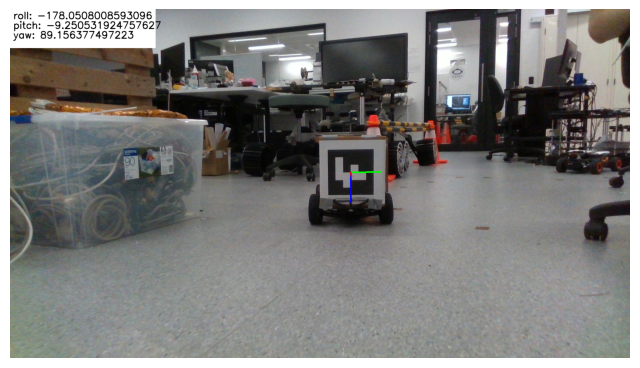

In [110]:
# draw the aruco marker on one of the images
color_intrinsics = np.loadtxt(f'{ego_path}/intrinsics.txt')
color_dist_coeffs = np.loadtxt(f'{ego_path}/dist_coeffs.txt')

IMAGE_INDEX = 30
img_to_show = df_tracking.iloc[IMAGE_INDEX]

img_path = f'{ego_path}/{int(img_to_show["time"])}.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rot_matrix = conv.get_rotation_matrix_from_quaternion(img_to_show['qx'],
                                                  img_to_show['qy'],
                                                  img_to_show['qz'],
                                                  img_to_show['qw'])
rvec, _ = cv2.Rodrigues(rot_matrix)
tvec = np.array([img_to_show['tx'], img_to_show['ty'], img_to_show['tz']])
# draw the aruco marker
frame_copy = cv2.drawFrameAxes(img, color_intrinsics, color_dist_coeffs, rvec, tvec, 0.1)

# add a background behind the text
cv2.rectangle(frame_copy, (0, 0), (450, 120), (255, 255, 255), -1)

# write the euler angles on the image
cv2.putText(frame_copy, f'roll: {math.degrees(img_to_show["roll"])}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
cv2.putText(frame_copy, f'pitch: {math.degrees(img_to_show["pitch"])}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
cv2.putText(frame_copy, f'yaw: {math.degrees(img_to_show["yaw"])}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

plt.grid(False)
plt.axis('off')
plt.imshow(frame_copy)

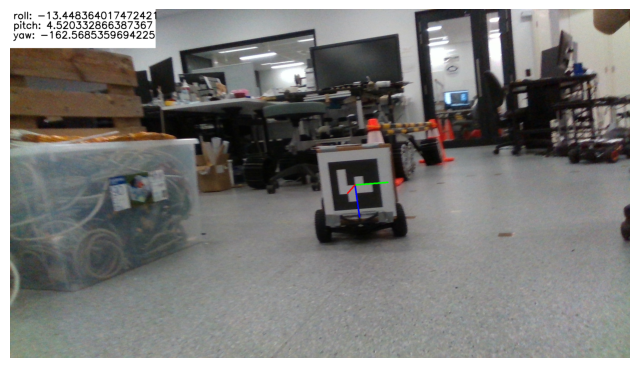

In [54]:
# draw the aruco marker on one of the images


color_intrinsics = np.loadtxt(f'{ego_path}/intrinsics.txt')
color_dist_coeffs = np.loadtxt(f'{ego_path}/dist_coeffs.txt')

IMAGE_INDEX = 54
img_to_show = df_tracking.iloc[IMAGE_INDEX]

img_path = f'{ego_path}/{int(img_to_show["time"])}.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rot_matrix = conv.get_rotation_matrix_from_quaternion(img_to_show['qx'],
                                                  img_to_show['qy'],
                                                  img_to_show['qz'],
                                                  img_to_show['qw'])
rvec, _ = cv2.Rodrigues(rot_matrix)
tvec = np.array([img_to_show['tx'], img_to_show['ty'], img_to_show['tz']])
# draw the aruco marker
frame_copy = cv2.drawFrameAxes(img, color_intrinsics, color_dist_coeffs, rvec, tvec, 0.1)

# add a background behind the text
cv2.rectangle(frame_copy, (0, 0), (450, 120), (255, 255, 255), -1)

# write the euler angles on the iamge
cv2.putText(frame_copy, f'roll: {math.degrees(img_to_show["roll_rotated"])}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
cv2.putText(frame_copy, f'pitch: {math.degrees(img_to_show["pitch_rotated"])}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)
cv2.putText(frame_copy, f'yaw: {math.degrees(img_to_show["yaw_rotated"])}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

plt.grid(False)
plt.axis('off')
plt.imshow(frame_copy)

1.0
Original euler angles: (-1.534312737815525, 1.4457841388537624, -1.5815755103330256)
New euler angles: (-3.1156015538481974, -0.12492856264037419, 1.5662125738947819)


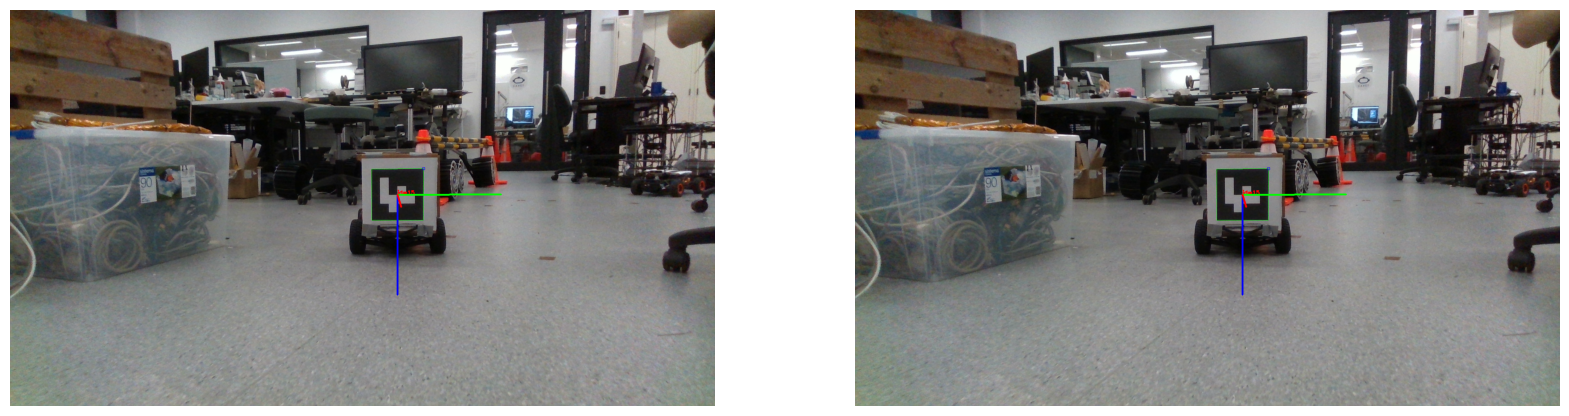

In [35]:
# convert rvec to quaternion and back
euler_ang = conv.get_euler_from_rodrigues(rvec)
rot_matrix = cv2.Rodrigues(rvec)[0]
quat = conv.get_quaternion_from_rotation_matrix(rot_matrix)
new_euler_ang = conv.get_euler_from_quaternion(*quat)
new_rvec = conv.get_rodrigues_from_quaternion(*quat)

img_with_aruco = cv2.aruco.drawDetectedMarkers(img.copy(), und_corners, und_ids)
cv2.drawFrameAxes(img_with_aruco, color_intrinsics, color_dist_coeffs, rvec, tvecs[0], 0.3)

img_with_new_rvec = cv2.aruco.drawDetectedMarkers(img.copy(), und_corners, und_ids)
cv2.drawFrameAxes(img_with_new_rvec, color_intrinsics, color_dist_coeffs, new_rvec, tvecs[0], 0.3)

print(f'Original euler angles: {euler_ang}')
print(f'New euler angles: {new_euler_ang}')
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.grid(False)
plt.axis('off')
plt.imshow(img_with_aruco)

plt.subplot(1, 2, 2)
plt.grid(False)
plt.axis('off')
plt.imshow(img_with_new_rvec)

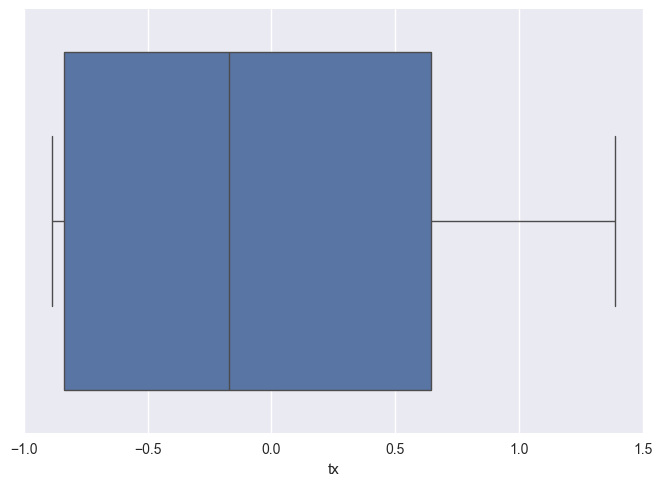

In [153]:
# find outliers in the x and y positions
sns.boxplot(x=ego_bev_df['tx'])
plt.show()

In [184]:
from numpy.polynomial.polynomial import Polynomial

degree = 5
CONFIDENCE_INTERVAL = 0.95

tx_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['tx'], degree)
ty_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['ty'], degree)
tz_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['tz'], degree)

In [156]:
tx_preds = tx_model(ego_bev_df['time_norm (sec)'])
ty_preds = ty_model(ego_bev_df['time_norm (sec)'])
tz_preds = tz_model(ego_bev_df['time_norm (sec)'])

tx_residuals = ego_bev_df['tx'] - tx_preds
ty_residuals = ego_bev_df['ty'] - ty_preds
tz_residuals = ego_bev_df['tz'] - tz_preds

tx_se = np.sqrt(sum(tx_residuals ** 2) / (len(tx_residuals) - degree - 1))
ty_se = np.sqrt(sum(ty_residuals ** 2) / (len(ty_residuals) - degree - 1))
tz_se = np.sqrt(sum(tz_residuals ** 2) / (len(tz_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

# (tx_residuals.sum() / (len(tx_residuals) - degree-1))
# tx_se = np.std(tx_residuals)

tx_confidence = z_score * tx_se
ty_confidence = z_score * ty_se
tz_confidence = z_score * tz_se

tx_confidence

0.04834799344438057

<AxesSubplot: xlabel='time_norm (sec)'>

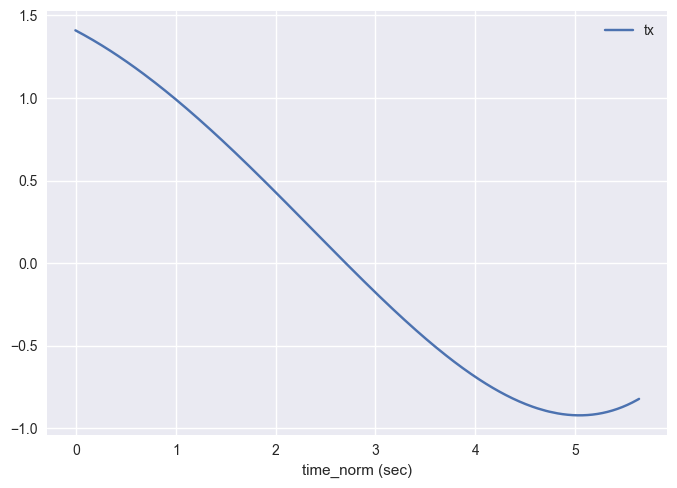

In [163]:
pd.DataFrame(np.vstack((ego_bev_df["time_norm (sec)"].values, tx_preds)).T, columns=["time_norm (sec)", "tx"]).plot(x="time_norm (sec)", y="tx")

<AxesSubplot: xlabel='time_norm (sec)', ylabel='tz'>

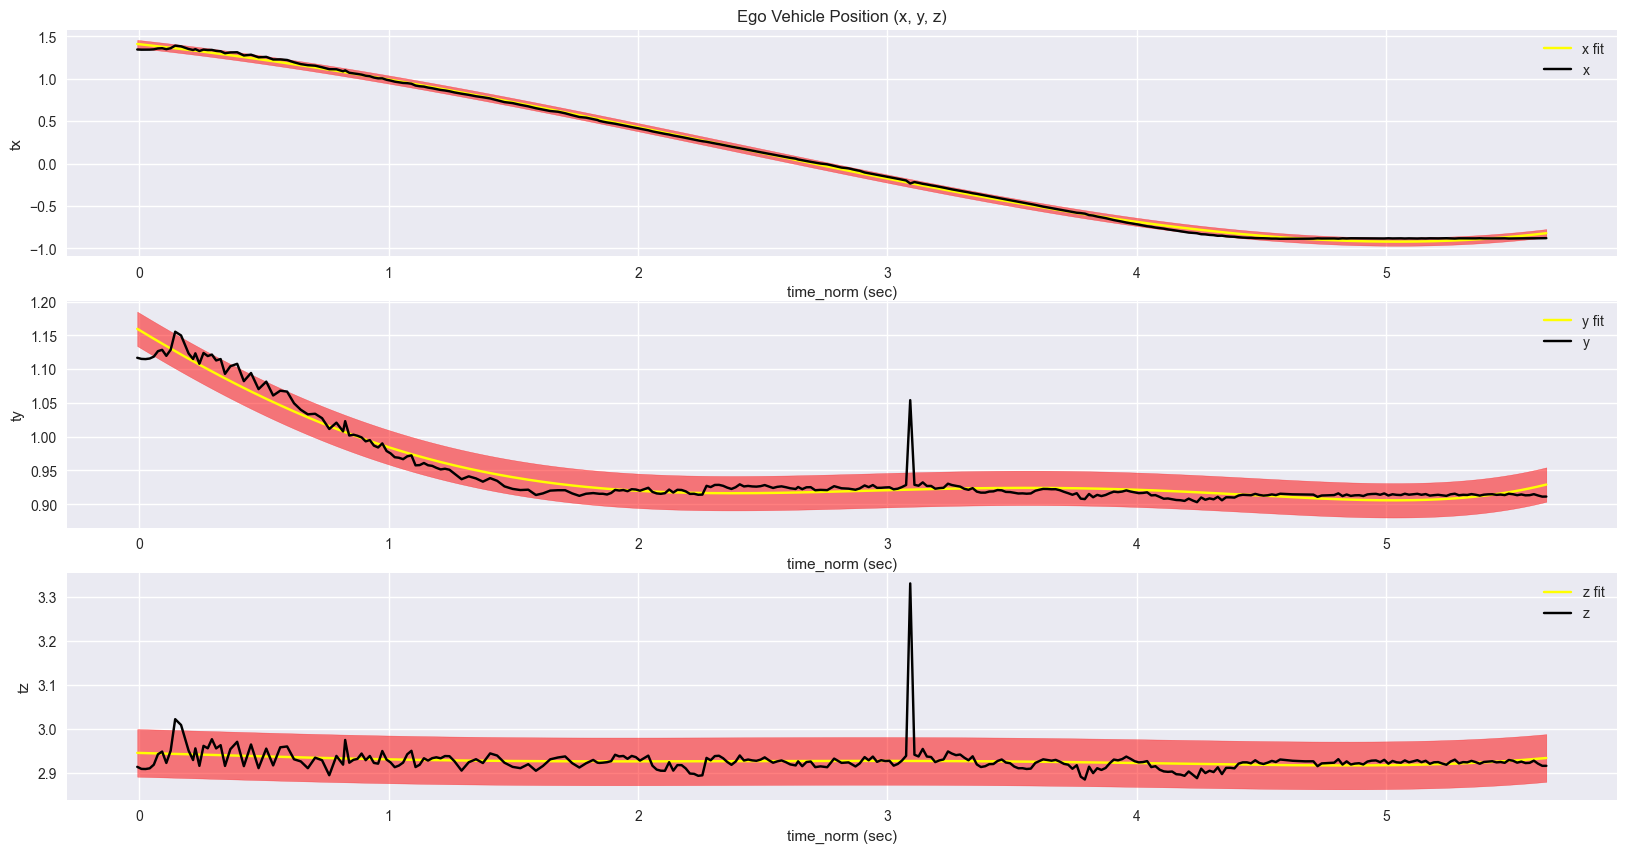

In [182]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Position (x, y, z)')
# plot the polynomial fit
plt.plot(ego_bev_df['time_norm (sec)'], tx_preds, label='x fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_df['time_norm (sec)'], tx_preds - tx_confidence, 
                    tx_preds + tx_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='tx', label='x', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_df['time_norm (sec)'], ty_preds, label='y fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_df['time_norm (sec)'], ty_preds - ty_confidence, 
                 ty_preds + ty_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='ty', label='y', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_df['time_norm (sec)'], tz_preds, label='z fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_df['time_norm (sec)'], tz_preds - tz_confidence, 
                 tz_preds + tz_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='tz', label='z', color='black')

<AxesSubplot: xlabel='time_norm (sec)', ylabel='yaw'>

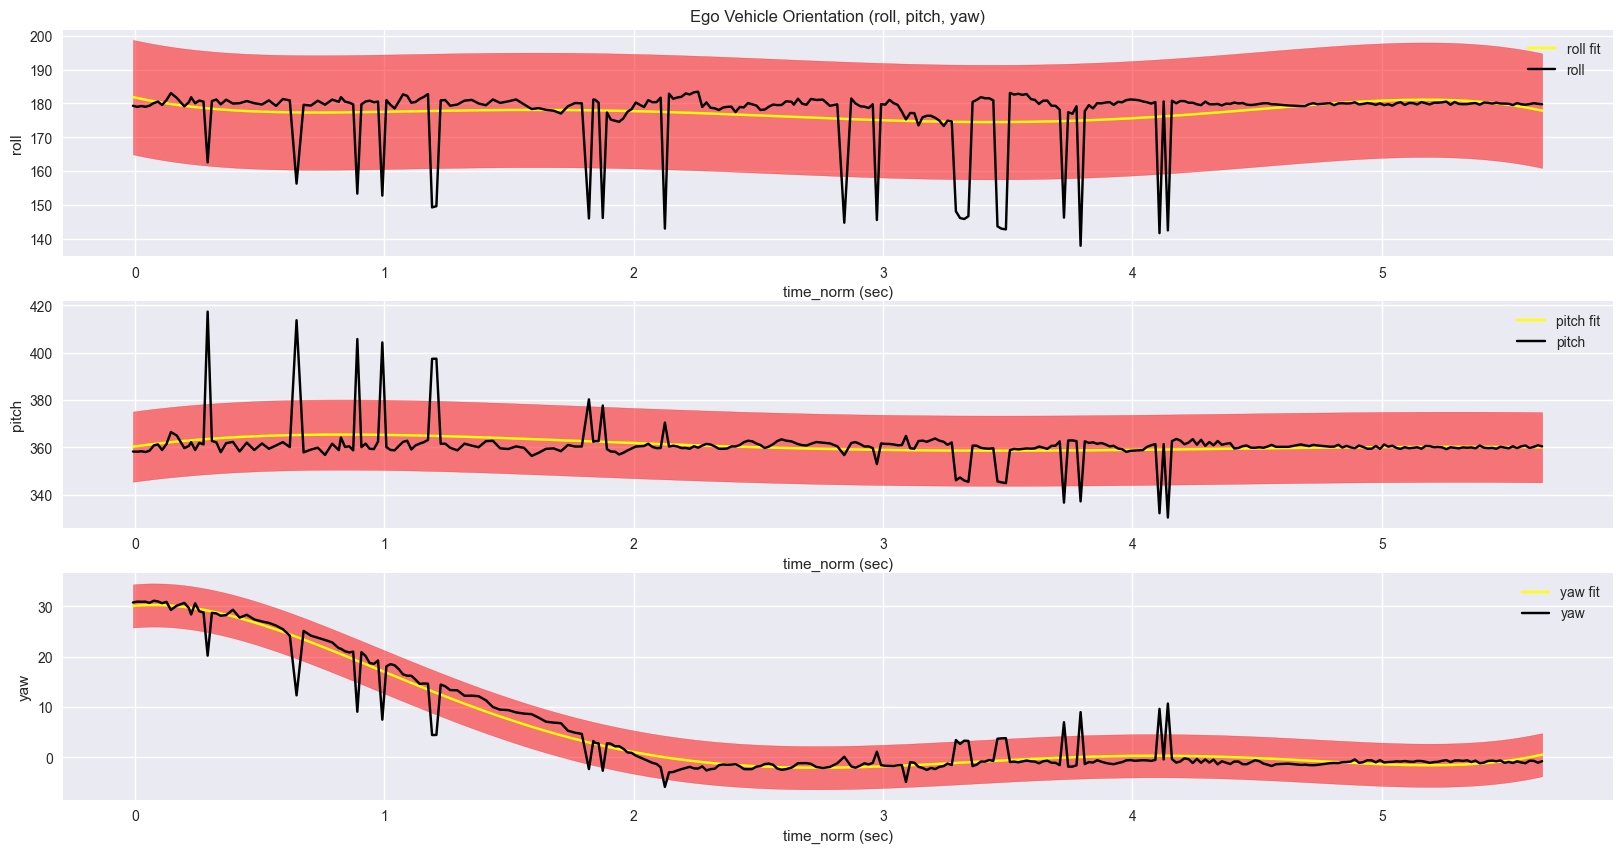

In [212]:
# plot the euler angles of ego_bev_df in the same way
degree = 5
roll_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['roll'], degree)
pitch_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['pitch'], degree)
yaw_model: Polynomial = Polynomial.fit(ego_bev_df['time_norm (sec)'], ego_bev_df['yaw'], degree)

roll_preds = roll_model(ego_bev_df['time_norm (sec)'])
pitch_preds = pitch_model(ego_bev_df['time_norm (sec)'])
yaw_preds = yaw_model(ego_bev_df['time_norm (sec)'])

roll_residuals = ego_bev_df['roll'] - roll_preds
pitch_residuals = ego_bev_df['pitch'] - pitch_preds
yaw_residuals = ego_bev_df['yaw'] - yaw_preds

roll_se = np.sqrt(sum(roll_residuals ** 2) / (len(roll_residuals) - degree - 1))
pitch_se = np.sqrt(sum(pitch_residuals ** 2) / (len(pitch_residuals) - degree - 1))
yaw_se = np.sqrt(sum(yaw_residuals ** 2) / (len(yaw_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - CONFIDENCE_INTERVAL) / 2)

roll_confidence = z_score * roll_se
pitch_confidence = z_score * pitch_se
yaw_confidence = z_score * yaw_se

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Orientation (roll, pitch, yaw)')
# plot the polynomial fit
plt.plot(ego_bev_df['time_norm (sec)'], roll_preds, label='roll fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(ego_bev_df['time_norm (sec)'], roll_preds - roll_confidence, 
                    roll_preds + roll_confidence, alpha=0.5, color='red')
sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='roll', label='roll', color='black')

plt.subplot(3, 1, 2)
plt.plot(ego_bev_df['time_norm (sec)'], pitch_preds, label='pitch fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_df['time_norm (sec)'], pitch_preds - pitch_confidence, 
                 pitch_preds + pitch_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='pitch', label='pitch', color='black')

plt.subplot(3, 1, 3)
plt.plot(ego_bev_df['time_norm (sec)'], yaw_preds, label='yaw fit', markersize='5', color='yellow')
plt.fill_between(ego_bev_df['time_norm (sec)'], yaw_preds - yaw_confidence, 
                 yaw_preds + yaw_confidence, alpha=0.5, color='red')

sns.lineplot(data=ego_bev_df, x='time_norm (sec)', y='yaw', label='yaw', color='black')